In [1]:
%load_ext autoreload
%autoreload 2
import ttpp
import ttpp.mmpp as mmpp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.auto as tqdm
import seaborn as sns
sns.set_style('whitegrid')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Load the data

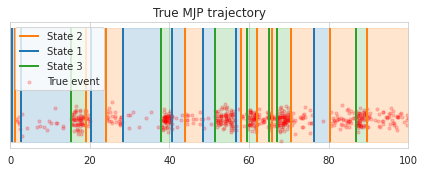

In [2]:
dataset = ttpp.mmpp.data.load_dataset('synthetic')
events = dataset['events'].view(-1, 1)
states = dataset['states']
durations = dataset['durations']
generator = dataset['generator']
prior = dataset['prior']
rates = dataset['rates']
K = len(prior)  # number of states
t_max = durations.sum().item()  # duration of the observed interval
ttpp.mmpp.utils.plot_mmpp(events, states, durations, t_max)

# Posterior inference with MCMC

In [7]:
# The diagonal of the generator must contain negative sum of total transition rates for each state for MCMC
generator_mcmc = generator.clone()
generator_mcmc.fill_diagonal_(0)
generator_mcmc[np.diag_indices_from(generator_mcmc)] = -generator_mcmc.sum(-1)
# Oversampling parameter needed for the MCMC sampler
omega = 2.0 * generator_mcmc.diag().abs().max().item()

# Sample the initial trajectory for MCMC
t_0 = torch.Tensor(mmpp.mcmc.sample_poisson(t_max, 1))
n_intervals = len(t_0) + 1

# Generate alternating z
z_0 = np.random.choice(K, size=300)
z_0 = np.array([v for i, v in enumerate(z_0) if i == 0 or v != z_0[i-1]][:len(t_0) + 1])
z_0 = torch.eye(K)[z_0]
path_init = mmpp.mcmc.MJPTrajectory(t_0, z_0, t_max)

In [8]:
# Sample the posterior trajectories
result = mmpp.mcmc.sample_mmpp_posterior(path_init, t_max, events, rates, generator_mcmc, prior, omega, tqdm=tqdm)

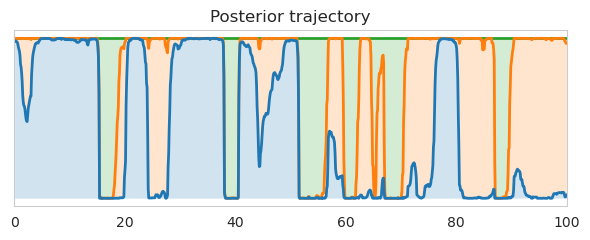

In [15]:
# Visualize the posterior trajectories
tau, z = mmpp.mcmc.stack_paths(result)
t_mcmc = tau.cumsum(-1)[:, :-1].unsqueeze(2)
z_mcmc = z
mmpp.utils.visualize_posterior(t_mcmc, z_mcmc, t_max, dpi=100)

# Variational inference

In [13]:
batch_size = 512
init_seq_len = 150
learning_rate = 1e-2
temp = 0.1

# q_t = ttpp.models.TriTPP(t_max, n_knots=50, n_blocks=2, block_size=4, lambda_init=t_max)
q_t = ttpp.models.ModulatedRenewal(t_max, n_knots=50, lambda_init=t_max)
params = mmpp.em.ParamsMMPP(K)
params.set_parameters(init=prior, generator=generator, rates=rates)

learnable_params = list(q_t.parameters()) + list(p for p in params.parameters() if p.requires_grad)
opt = torch.optim.Adam(learnable_params, lr=learning_rate, weight_decay=1e-6)

epoch    0, loss = -686.327


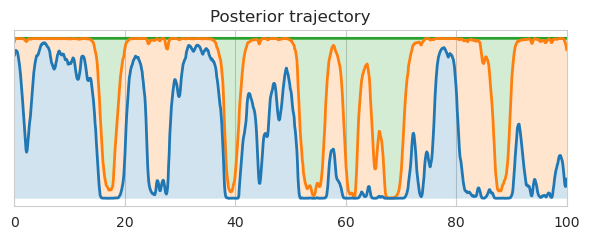

epoch  100, loss = -768.562


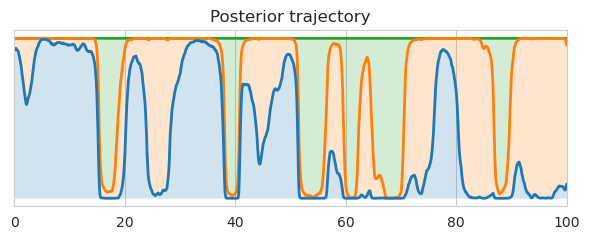

epoch  200, loss = -780.482


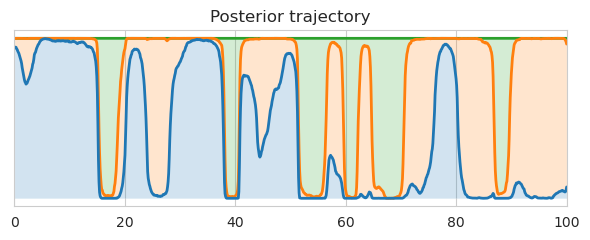

In [14]:
max_epochs = 201
display = 100

for epoch in tqdm.trange(max_epochs):
    opt.zero_grad()
    t_raw = q_t.rsample(batch_size, init_seq_len=init_seq_len)
    t, tau, inside_jump = mmpp.utils.clip_times(t_raw, t_max, temp)

    log_like_obs = mmpp.em.log_like_poisson(t, tau, t_max, events, params.rates, temp=temp)
    log_like_mjp = mmpp.em.log_like_mjp(tau, params.generator)
    log_like = log_like_obs + log_like_mjp

    log_marginals, state_transitions = mmpp.em.forward_backward(log_like, params.log_transition, params.log_init)
    loss = -mmpp.em.elbo_mjp(q_t, t, inside_jump, log_like, log_marginals, state_transitions, params)
    loss.backward()
    opt.step()
    if epoch % display == 0:
        print(f'epoch {epoch:4d}, loss = {loss.item():.3f}')
        mmpp.utils.visualize_posterior(t, log_marginals.exp(), t_max, dpi=100)